[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tdene/synth_opt_adders/blob/master/docs/notebooks/sparseness.ipynb)

# Adder-specific optimizations [Sparseness]

### Setup (RUN ME before executing any code in this section)

In [ ]:
!pip install --upgrade git+https://github.com/tdene/synth_opt_adders.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tdene/synth_opt_adders.git to /tmp/pip-req-build-rfeopu6m
  Running command git clone -q https://github.com/tdene/synth_opt_adders.git /tmp/pip-req-build-rfeopu6m


### Doesn't everything discussed so far apply to any operation, not just binary addition?

Yes. It does.

Here is one thing that is slightly less general, but still applies to a large variety of operations such as binary addition.

### Integrating the post-processing logic into the tree

As previously mentioned, binary addition consists of a local and a non-local aspect.<br>
Post-processing logic is used to combine these into a final answer.

Can this post-processing also associate?

Yes! This is a concept well-known as sparsenesss. The normal form of the post-processing logic gate is the XOR seen below, while its associative form requires the MUX gate seen below. Note that the two cells have nearly identical footprints, which is to say, swapping the XOR for a MUX can be done at little cost.

While both XOR and MUX are inherently associative the key difference is that the MUX gate has an extra input available, allowing it to process tuples in a similar fashion to the main recurrence node.

![png](https://raw.githubusercontent.com/tdene/synth_opt_adders/main/docs/diagrams/xor_vs_mux.png)

### Regular sparseness

Here is an example of a classic structure with regularly-applied sparseness of degree 1.

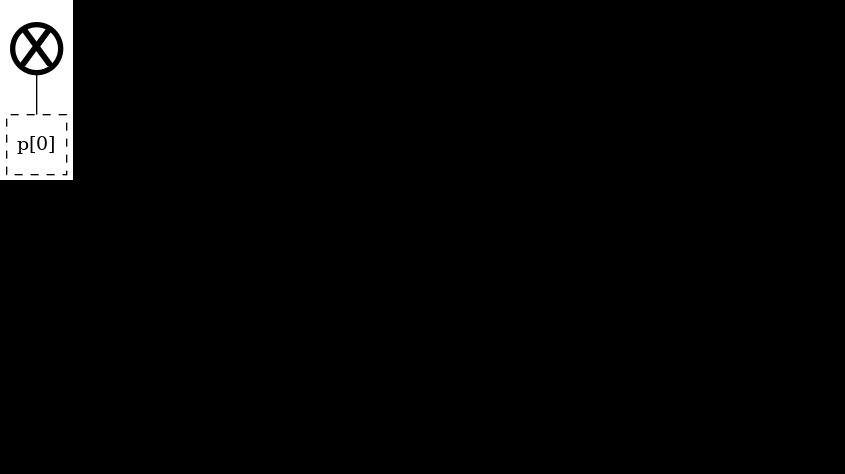

In [10]:
from pptrees.AdderForest import AdderForest as forest

# Sklansky structure
f = forest(9)
for t in f.trees[2:]:
  t.rbalance(t.root[1])
# Apply regular sparseness of degree 1
for a in range(len(f.trees[2:])):
  # Skip the first two trees, of widths 0 and 1
  t = f[a+2]
  # Apply sparseness every 2 trees
  if (a % 2 == 1):
    # Apply only 1 degree of sparseness
    t.left_shift(t.root[1].leftmost_leaf().parent)
f

Every other tree shifts exactly 1 node onto the left side of the tree.

Watch the GIF carefully. Notice that each frame with sparseness applied to it makes use of the same logic as the previous frame.

This saves a large amount of area and power consumption, as the same sub-trees can be re-used.

### Regular sparseness of higher degree

Here is an example of a classic structure with regularly-applied sparseness of degree 3, such as in Naffziger's adder or Lynch-Swartzlander's spanning-tree adder.

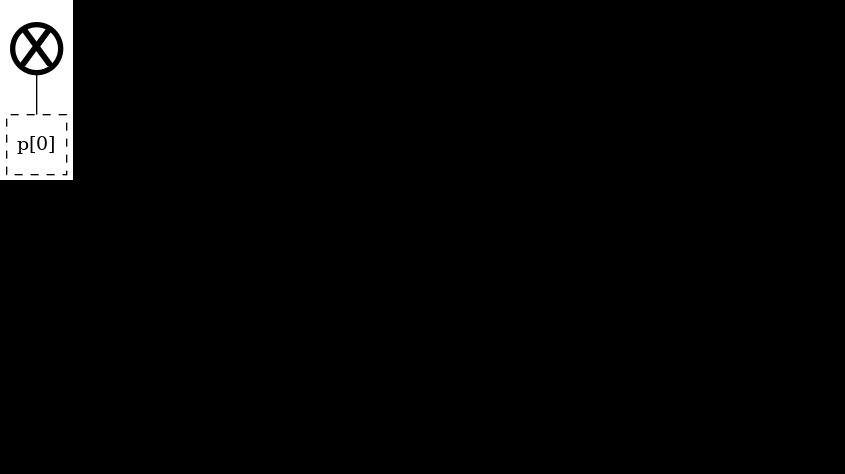

In [11]:
from pptrees.AdderForest import AdderForest as forest

# Sklansky structure
f = forest(9)
for t in f.trees[2:]:
  t.rbalance(t.root[1])
# Apply regular sparseness of degree 3
for a in range(len(f.trees[4:])):
  # Skip the first 4 trees, of widths 0, 1, 2, 3
  t = f[a+4]
  # Apply sparseness every 4 trees
  if (a % 4 != 0):
    # Apply multiple degrees of sparseness
    t.left_rotate(t.root[1])
f

Every fourth tree shifts $i\%4$ trees onto the left side of the tree.

Watch the GIF carefully. Note the 4 consecutive frames that all share the same right half of the tree. Again, this can save a large amount of area and power consumption.

### Irregular sparseness

If sparseness can save a lot of area and power consumption by knocking out a whole section of the tree, would it not make sense to apply sparseness more aggressively on bigger trees?

That is to say, instead of applying sparseness every 2 or every 4 nodes, why not apply sparseness of degree 8 on trees 54 through 64, sparseness of degree 6 on trees 40 through 54, sparseness of degree 5 on tree 39 just for fun, sparseness of degree 4 on trees 20 through 39, etecetera.

It certainly sounds like this would be superior to regular applications of sparseness. Yet there are almost no examples of this method in literature.

Why? It is ridiculously hard to do by hand.

Luckily, I've made a tool that can do it.

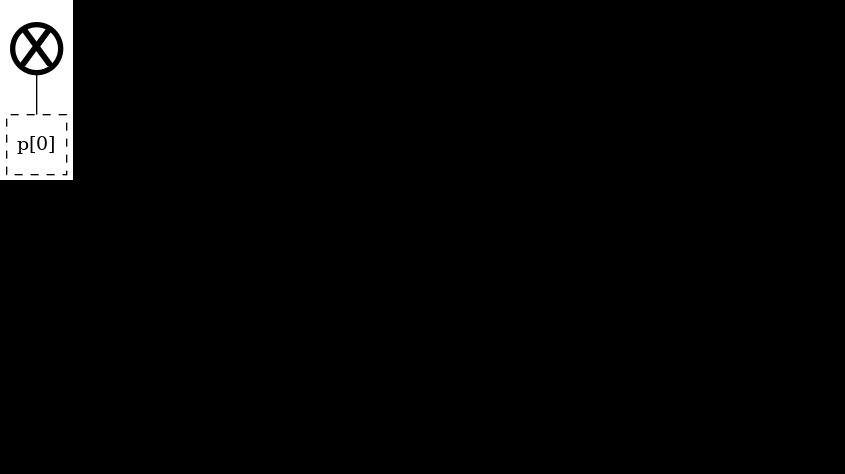

In [12]:
from pptrees.AdderForest import AdderForest as forest

# Sklansky structure
f = forest(9)
for t in f.trees[2:]:
  t.rbalance(t.root[1])
# Apply arbitrary amounts of sparseness, for illustrative purposes
## One shift on tree 2
f[2].left_shift(f[2].root[1].leftmost_leaf().parent)
## Two shifts on tree 4
f[4].left_rotate(f[4].root[1])
## Three shifts on tree 8
f[8].left_shift(f[8].root[1].leftmost_leaf().parent)
f[8].left_shift(f[8].root[1].leftmost_leaf().parent)
f[8].left_shift(f[8].root[1].leftmost_leaf().parent)
## Avoid spoiling the next sub-section
f[8].right_rotate(f[8].root[0][0])
f[8].right_rotate(f[8].root[0][0])
f

### Nested sparseness

Viewing sparseness through the lens of this new style of adder diagrams raises an interesting question.

If sparseness is just the action of shifting some nodes onto the left side of the tree.

Can they not be shifted even further left, in a sort of "nested" sparseness?

Indeed they can, which leads to novel structures not previously seen in literature.

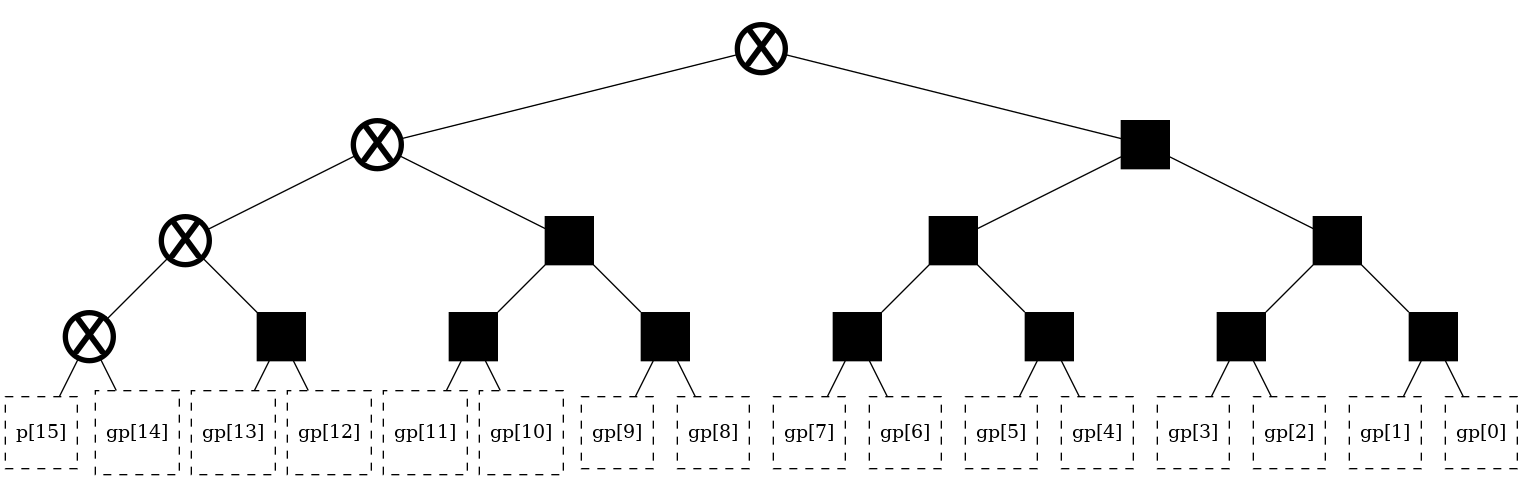

In [13]:
from pptrees.AdderTree import AdderTree as tree

# Fully-balanced tree
t = tree(16)
t.balance(t.root)
t

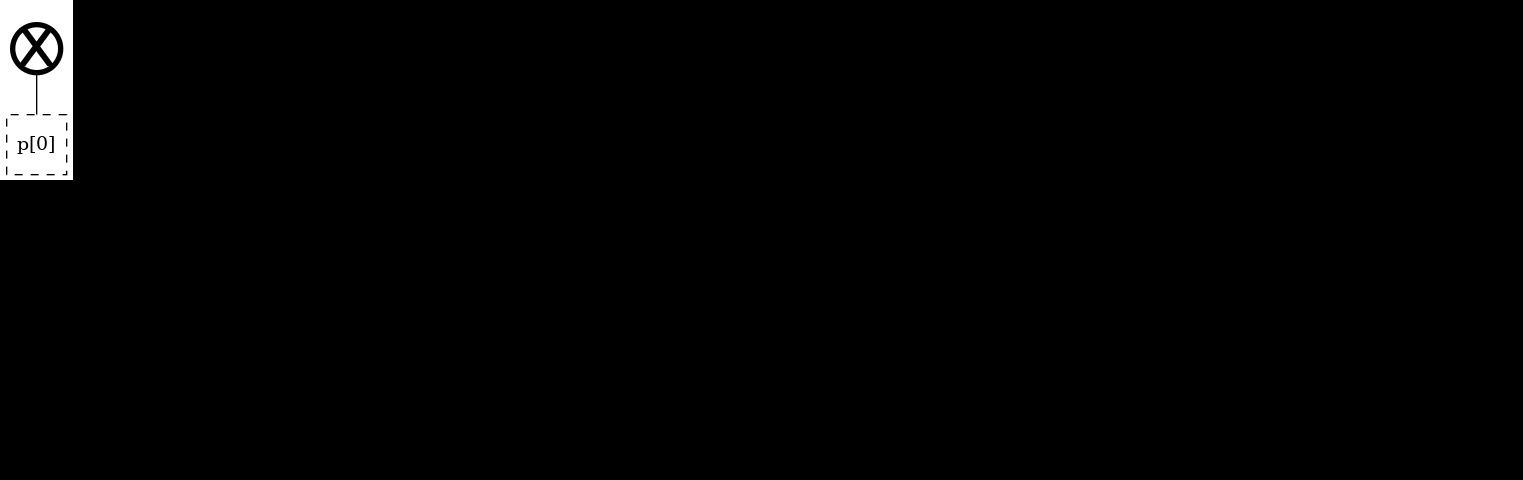

In [14]:
from pptrees.AdderForest import AdderForest as forest

# Fully-balanced forest
f = forest(16)
for t in f.trees[2:]:
  t.rbalance(t.root)
f

### Adder-specific?

Note that this optimization is not adder-specific, but instead can be applied to any operation where the local and non-local components similarly combine through the use of a multiplexer.

A simple example is a leading-zero detection circuit that feeds into a shifter. The shifter acts as the local component, allowing it to be integrated into the tree in similar fashion as with addition's post-processing node.